In [1]:
# imports
from itertools import combinations
# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, BayesianRidge, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE, RFECV, SequentialFeatureSelector
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score, mean_squared_error, silhouette_score, silhouette_samples
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn_extra.cluster import KMedoids
import upsetplot as uplt

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn
import matplotlib.cm as cm

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

from scipy.stats import pearsonr

sys.path.append("../")

import utils_ML as uml

from scipy.stats import pearsonr

In [2]:
protein_columns = pd.read_csv("NSAF_50.csv", index_col = "assay_id").columns

In [3]:
# Load datasets
data_combat = pd.read_csv("combat_NSAF_50.csv", index_col = "assay_id")
data_quantile = pd.read_csv("quantile_norm_NSAF_50.csv", index_col = "assay_id")
data_median_norm = pd.read_csv("median_scaling_50.csv", index_col = "Unnamed: 0")
data_nsaf = pd.read_csv("NSAF_50.csv", index_col = "assay_id")
data_nsaf = np.log2(data_nsaf)

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data_combat.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data_combat.sort_index(inplace=True)
data_quantile.sort_index(inplace=True)
data_median_norm.sort_index(inplace=True)
data_nsaf.sort_index(inplace=True)
meta.sort_index(inplace=True)

missing_value_mask = data_nsaf.isna()
data_combat = data_combat.where(~missing_value_mask, other=np.nan)

data_combat = data_combat.reset_index(drop=True).rename(columns={data_combat.columns[x]:x for x in range(len(data_combat.columns))})
data_quantile = data_quantile.reset_index(drop=True).rename(columns={data_quantile.columns[x]:x for x in range(len(data_quantile.columns))})
data_median_norm = data_median_norm.reset_index(drop=True).rename(columns={data_median_norm.columns[x]:x for x in range(len(data_median_norm.columns))})
data_nsaf = data_nsaf.reset_index(drop=True).rename(columns={data_nsaf.columns[x]:x for x in range(len(data_nsaf.columns))})

mapper = zip(meta.PXD_accession.unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession.nunique()))
mapper = dict(mapper)

In [4]:
target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [5]:
labels = np.array(meta.Group)

In [ ]:
# Effect of stochastic imputation on feature selection.
selected_features = []
for x in range(20):
    imputer = uml.MNAR_MCAR_Imputer(max_iter=15)
    imputer.fit(data_quantile, labels)
    imputed_df_F = imputer.transform(data_quantile, labels)

    # Select features with anova
    f_classif_features = SelectKBest(f_classif, k = 100).fit(imputed_df_F, labels)
    selected_features.append(f_classif_features)

In [30]:
all_jaccard = []
for i1,i2 in combinations(range(20), 2):
    prots1 = set(pd.DataFrame({"F1": selected_features[i1].scores_}).sort_values(by="F1", ascending=False)[:100].index)
    prots2 = set(pd.DataFrame({"F1": selected_features[i2].scores_}).sort_values(by="F1", ascending=False)[:100].index)

    intersection_size = len(prots1.intersection(prots2))
    union_size = len(prots1.union(prots2))
    all_jaccard.append(intersection_size/union_size)

In [33]:
np.mean(all_jaccard)

0.8359041585331612

In [6]:
labels = np.array(meta.Group)
#mmi_quant = uml.MNAR_MCAR_Imputer(max_iter=15)
mmi_quant = uml.LowestValueImputerGaussian()
mmi_quant.fit(data_quantile, labels)
imputed_df_quant = mmi_quant.transform(data_quantile, labels)
mm_scaler = MinMaxScaler()
minmax_df_quant = mm_scaler.fit_transform(imputed_df_quant)

In [7]:
f_values, p_values = f_classif(imputed_df_quant, labels)
mi_values = mutual_info_classif(imputed_df_quant, labels)

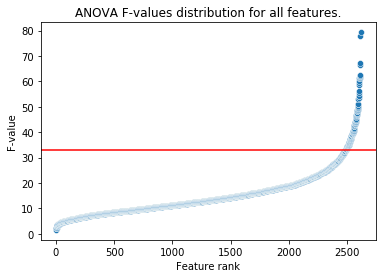

In [10]:
sns.scatterplot(y=np.sort(f_values),x=list(range(1,2616)))
plt.title("ANOVA F-values distribution for all features.")
plt.xlabel("Feature rank")
plt.ylabel("F-value")
plt.axhline(f_values.mean()+1.96*f_values.std(), c="r")

In [29]:
-np.log10(.01/2615)

5.417471693203293

2613


Text(0, 0.5, '-log10(p-value)')

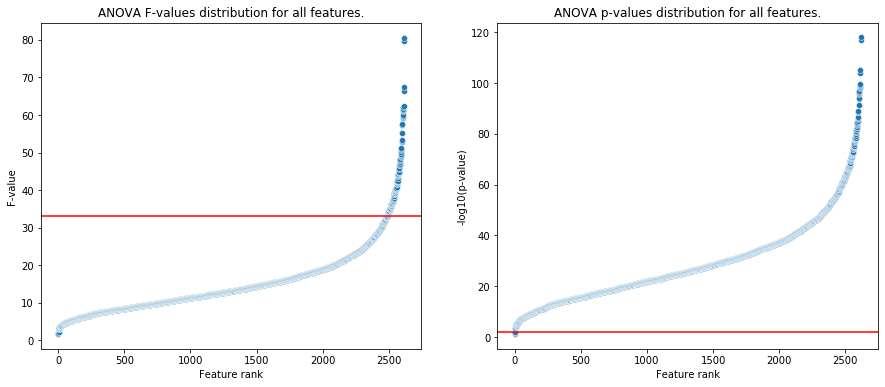

In [9]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(y=np.sort(f_values),x=list(range(1,2616)), ax=ax[0])
sns.scatterplot(y=np.sort(-np.log10(p_values)),x=list(range(1,2616)), ax=ax[1])
ax[1].axhline(2, c="r")
ax[0].axhline(f_values.mean()+1.96*f_values.std(), c="r")

print((-np.log10(p_values)>2).sum())

ax[0].set_title("ANOVA F-values distribution for all features.")
ax[0].set_xlabel("Feature rank")
ax[0].set_ylabel("F-value")

ax[1].set_title("ANOVA p-values distribution for all features.")
ax[1].set_xlabel("Feature rank")
ax[1].set_ylabel("-log10(p-value)")

In [10]:
sign_mask = f_values > f_values.mean()+1.96*f_values.std()
sign_mask.sum()

129

In [11]:
feature_scores = pd.DataFrame({"Protein": protein_columns, "F-score": f_values, "MI-score": mi_values})

In [20]:
feature_scores.max(axis=0)

Protein       Q9Y6Y8
F-score      80.6279
MI-score    0.986131
dtype: object

In [13]:
feature_scores.sort_values(by="MI-score")

,Protein,F-score,MI-score
2614,Q9Y6Y8,7.741600,0.127599
2203,Q9HD33,8.392619,0.133219
1581,Q8IYI6,6.872404,0.136996
1293,Q2NL82,6.154631,0.138747
29,O00232,5.481176,0.144834
...,...,...,...
389,P05787,79.693376,0.813372
638,P31947,80.627879,0.816828
1178,Q14315,43.907142,0.842977
146,O43707,50.069152,0.848989


In [14]:
feature_scores.sort_values(by="F-score")

,Protein,F-score,MI-score
1306,Q3ZAQ7,1.681905,0.426470
1954,Q99808,1.952325,0.308775
1625,Q8NB46,2.222921,0.276243
2530,Q9Y3B7,2.223958,0.156097
724,P43897,2.899666,0.166722
...,...,...,...
417,P08670,62.273215,0.781741
741,P46821,66.329259,0.639112
447,P11388,67.499317,0.721220
389,P05787,79.693376,0.813372


Text(0, 0.5, 'F-value')

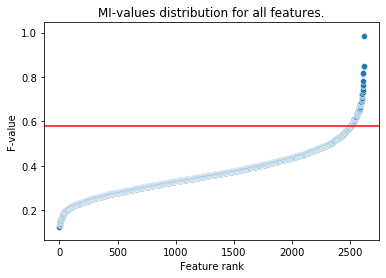

In [15]:
sns.scatterplot(y=np.sort(mi_values),x=list(range(1,2616)))
plt.title("MI-values distribution for all features.")
plt.axhline(mi_values.mean()+1.96*mi_values.std(), c="r")
plt.xlabel("Feature rank")
plt.ylabel("F-value")

In [16]:
sign_mask_mi = mi_values > mi_values.mean()+1.96*mi_values.std()
sign_mask_mi.sum()

111

Text(0, 0.5, 'MI-value')

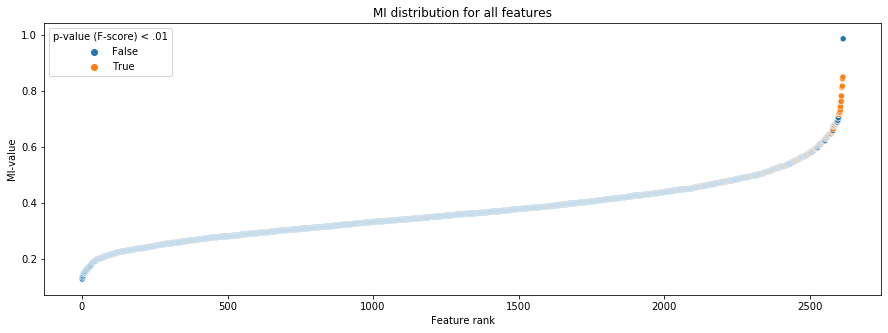

In [17]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=pd.DataFrame({"MI": mi_values, "p-value (F-score) < .01": sign_mask}).sort_values(by="MI"),
                 y="MI",x=list(range(1,2616)), hue="p-value (F-score) < .01")
plt.title("MI distribution for all features")
plt.xlabel("Feature rank")
plt.ylabel("MI-value")

In [21]:
F_combat = f_values

Text(0, 0.5, 'F-value')

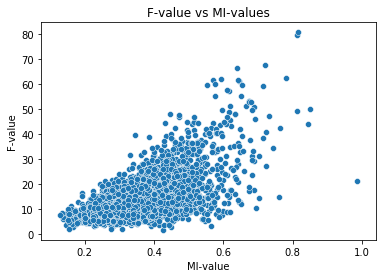

In [23]:
sns.scatterplot(x=mi_values, y=f_values)
plt.title("F-value vs MI-values")
plt.xlabel("MI-value")
plt.ylabel("F-value")

In [24]:
from scipy import stats
stats.spearmanr(a=mi_values, b=f_values)

SpearmanrResult(correlation=0.5613671190516355, pvalue=4.605106609321106e-217)

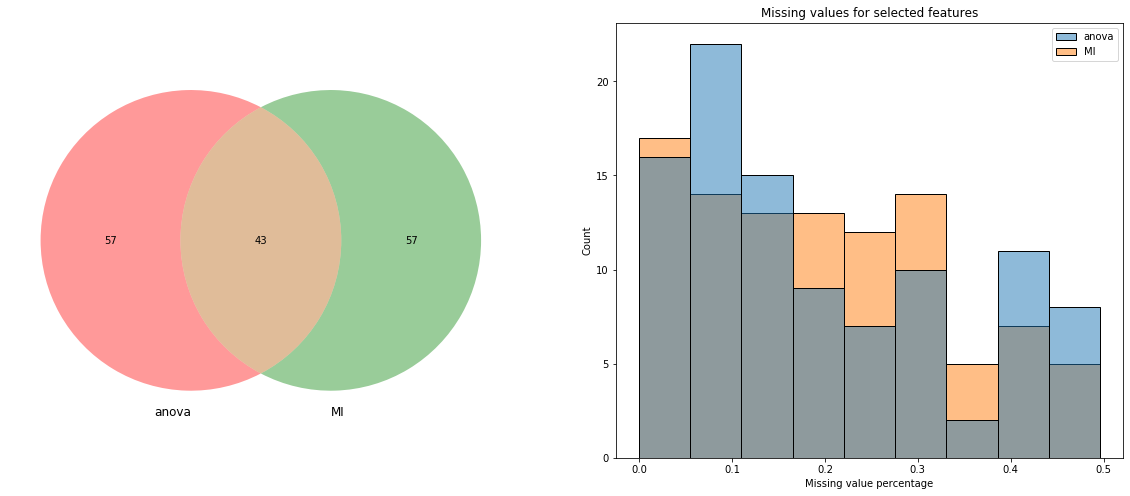

In [94]:
#chi2_features = SelectKBest(chi2, k = 200).fit(imputed, targets)
f_classif_features = SelectKBest(f_classif, k = 100).fit(imputed_df_quant, labels)
mi_features = SelectKBest(mutual_info_classif, k = 100).fit(imputed_df_quant, labels)

# Parsing
MI_f = pd.Series(mi_features.scores_, index = imputed_df_quant.columns).reset_index(name = "MI").rename(columns = {"index":"path_id"}).sort_values(by = "MI", ascending = False).reset_index()
f_features = pd.Series(f_classif_features.scores_, index = imputed_df_quant.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
#chi2_scores = pd.Series(chi2_features.scores_, index = processed_data.columns).reset_index(name = "chi2_scores").rename(columns = {"index":"path_id"}).sort_values(by = "chi2_scores", ascending = False).reset_index()

#chi2_set = set(chi2_scores.iloc[:200,1])
anova_set = set(f_features.iloc[:100,1])
MI_set = set(MI_f.iloc[:100,1])

# "--------------------------------"
# Solution: reset the column names of anova_set and MI_set
missing_percentage = pd.concat([data_quantile.loc[:, anova_set].isna().sum().reset_index(drop=True) / 518, 
                                data_quantile.loc[:, MI_set].isna().sum().reset_index(drop=True) / 518], 
          axis=1, ignore_index=True)

fig, ax = plt.subplots(1,2, figsize= (20,8), facecolor = "white")

ax[1].set_title("Missing values for selected features")
ax[1].set_xlabel("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "anova", 1: "MI"}), ax=ax[1])

venn.venn2([anova_set, MI_set], ("anova", "MI"), ax=ax[0])

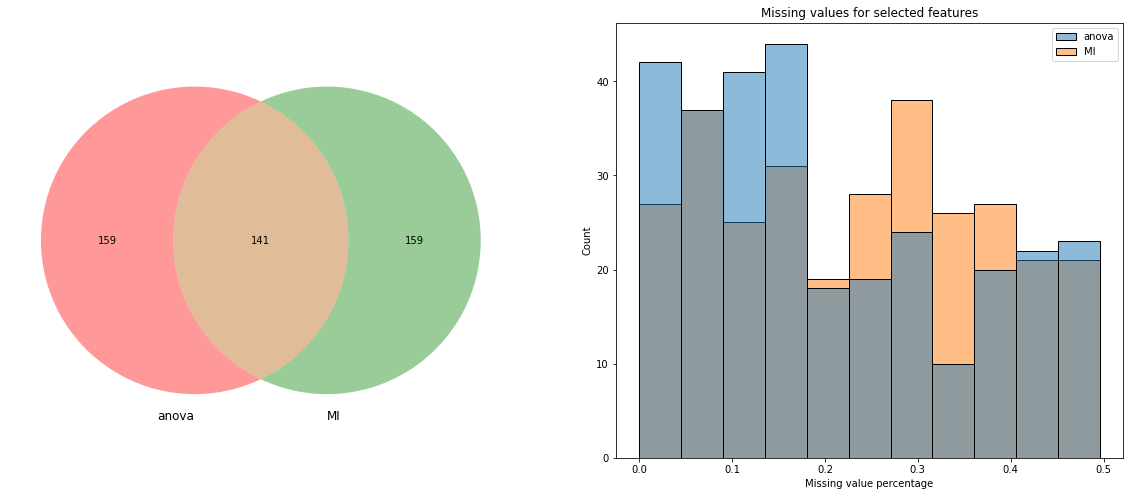

In [55]:
#chi2_features = SelectKBest(chi2, k = 200).fit(imputed, targets)
f_classif_features = SelectKBest(f_classif, k = 300).fit(imputed_df_quant, labels)
mi_features = SelectKBest(mutual_info_classif, k = 300).fit(imputed_df_quant, labels)

# Parsing
MI_f = pd.Series(mi_features.scores_, index = imputed_df_quant.columns).reset_index(name = "MI").rename(columns = {"index":"path_id"}).sort_values(by = "MI", ascending = False).reset_index()
f_features = pd.Series(f_classif_features.scores_, index = imputed_df_quant.columns).reset_index(name = "f_value").rename(columns = {"index":"path_id"}).sort_values(by = "f_value", ascending = False).reset_index()
#chi2_scores = pd.Series(chi2_features.scores_, index = processed_data.columns).reset_index(name = "chi2_scores").rename(columns = {"index":"path_id"}).sort_values(by = "chi2_scores", ascending = False).reset_index()

#chi2_set = set(chi2_scores.iloc[:200,1])
anova_set = set(f_features.iloc[:300,1])
MI_set = set(MI_f.iloc[:300,1])

# "--------------------------------"
# Solution: reset the column names of anova_set and MI_set
missing_percentage = pd.concat([data_quantile.loc[:, anova_set].isna().sum().reset_index(drop=True) / 518, 
                                data_quantile.loc[:, MI_set].isna().sum().reset_index(drop=True) / 518], 
          axis=1, ignore_index=True)

fig, ax = plt.subplots(1,2, figsize= (20,8), facecolor = "white")

ax[1].set_title("Missing values for selected features")
ax[1].set_xlabel("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "anova", 1: "MI"}), ax=ax[1])

venn.venn2([anova_set, MI_set], ("anova", "MI"), ax=ax[0])

In [85]:
selector_lr = RFECV(LogisticRegression(max_iter=10000, penalty="l1", solver = "liblinear", multi_class="ovr", class_weight=weights), step=50, scoring='f1_macro')
selector_lr = selector_lr.fit(minmax_df_quant, targets)

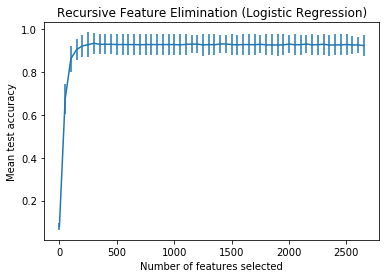

In [71]:
n_scores = len(selector_lr.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores*50,50),
    selector_lr.cv_results_["mean_test_score"],
    yerr=selector_lr.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination (Logistic Regression)")
plt.show()

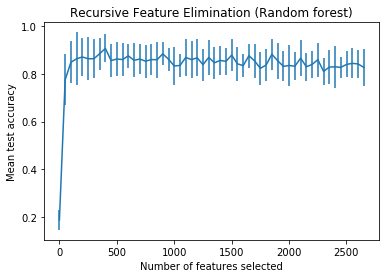

In [86]:
estimator_rf = RandomForestClassifier(class_weight=weights)
selector_rf = RFECV(estimator_rf, step=50, scoring="f1_macro")
selector_rf = selector_rf.fit(minmax_df_quant, targets)

n_scores = len(selector_lr.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores*50,50),
    selector_rf.cv_results_["mean_test_score"],
    yerr=selector_rf.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination (Random forest)")
plt.show()

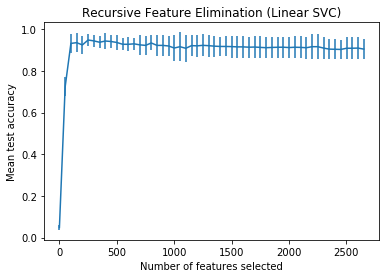

In [87]:
estimator_svc = SVC(kernel="linear", class_weight=weights)
selector_svc = RFECV(estimator_svc, step=50, scoring="f1_macro")
selector_svc = selector_svc.fit(minmax_df_quant, targets)

n_scores = len(selector_lr.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores*50,50),
    selector_svc.cv_results_["mean_test_score"],
    yerr=selector_svc.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination (Linear SVC)")
plt.show()

In [88]:
pd.concat([pd.Series(selector_lr.cv_results_["mean_test_score"], name="Logistic Regression"),
            pd.Series(selector_rf.cv_results_["mean_test_score"], name = "Random forest"),
            pd.Series(selector_svc.cv_results_["mean_test_score"], name = "Linear SVM")], axis=1).melt()

,variable,value
0,Logistic Regression,0.084431
1,Logistic Regression,0.677432
2,Logistic Regression,0.857772
3,Logistic Regression,0.882155
4,Logistic Regression,0.920057
...,...,...
157,Linear SVM,0.903031
158,Linear SVM,0.908793
159,Linear SVM,0.908793
160,Linear SVM,0.909573


In [89]:
pd.concat([pd.Series(selector_lr.cv_results_["mean_test_score"], name="Logistic Regression"),
            pd.Series(selector_rf.cv_results_["mean_test_score"], name = "Random forest"),
            pd.Series(selector_svc.cv_results_["mean_test_score"], name = "Linear SVM")], axis=1)

,Logistic Regression,Random forest,Linear SVM
0,0.084431,0.186467,0.048265
1,0.677432,0.775331,0.723973
2,0.857772,0.848884,0.932004
3,0.882155,0.863672,0.935575
4,0.920057,0.871172,0.924708
5,0.926769,0.863666,0.948326
6,0.922976,0.863548,0.944042
7,0.927407,0.884685,0.937503
8,0.929193,0.907086,0.943502
9,0.927398,0.856017,0.941093


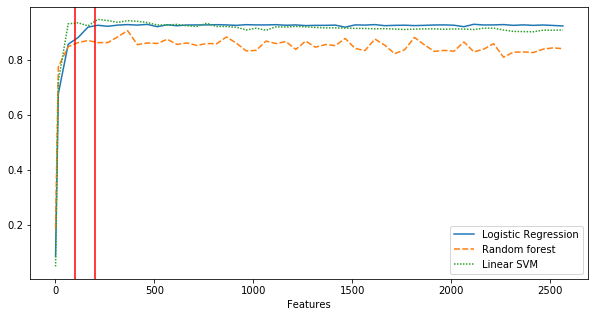

In [92]:
# Seems optimal at 200-300 features
plt.figure(figsize=(10,5))
sns.lineplot(data=pd.concat([pd.Series(selector_lr.cv_results_["mean_test_score"], name="Logistic Regression"),
            pd.Series(selector_rf.cv_results_["mean_test_score"], name = "Random forest"),
            pd.Series(selector_svc.cv_results_["mean_test_score"], name = "Linear SVM"),
            pd.Series([1]+list(range(15,2615,50)), name="Features")], axis=1).set_index("Features"))
plt.axvline(100,c="r")
plt.axvline(200,c="r")

In [27]:
fs_bagged = uml.FeatureSelector("anova MI RF SVC LR".split(), num_features = 300, threshold = .5)
selected_minmax_quant = fs_bagged.fit_transform(minmax_df_quant, targets)

In [28]:
selected_minmax_quant.shape

(518, 161)

In [31]:
selected_proteins = protein_columns[selected_minmax_quant.columns]

In [32]:
with open("selected_features.txt", 'w') as fp:
    fp.write('\n'.join(selected_proteins))

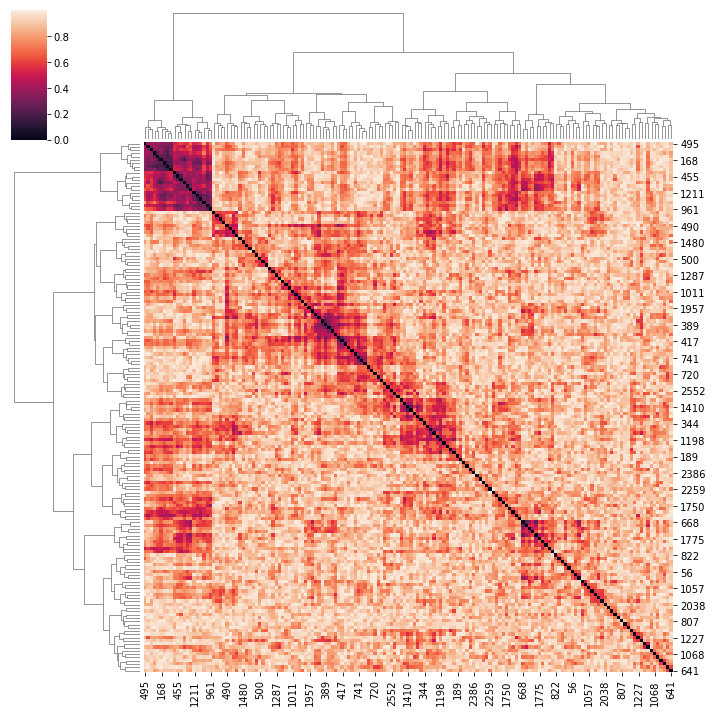

In [41]:
sns.clustermap(1-abs(pd.DataFrame(selected_minmax_quant).corr()), method='ward', metric="euclidean")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


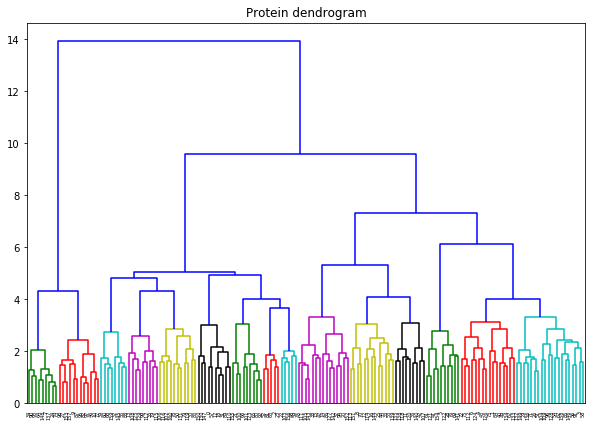

In [57]:
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import squareform

plt.figure(figsize=(10, 7))
plt.title("Protein dendrogram")

# Selecting Annual Income and Spending Scores by index
clusters = sch.linkage(1-abs(pd.DataFrame(selected_minmax_quant).corr()), 
            method='ward',metric="euclidean")

sch.dendrogram(Z=clusters, color_threshold=3.5)
cluster_labels = sch.fcluster(clusters, t=3.5, criterion="distance")
plt.show()

In [49]:
selected_proteins[cluster_labels == 7]

Index(['P08670', 'P46821', 'P48681', 'Q02952', 'Q14315', 'Q16352', 'Q16658',
       'Q96CX2', 'Q9Y446'],
      dtype='object')

In [60]:
for x in selected_proteins[cluster_labels == 1]:
    print(x)

O60264
P11388
P16403
P46013
P62805
Q14151
Q14676
Q9NR30
Q9UIG0


---

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


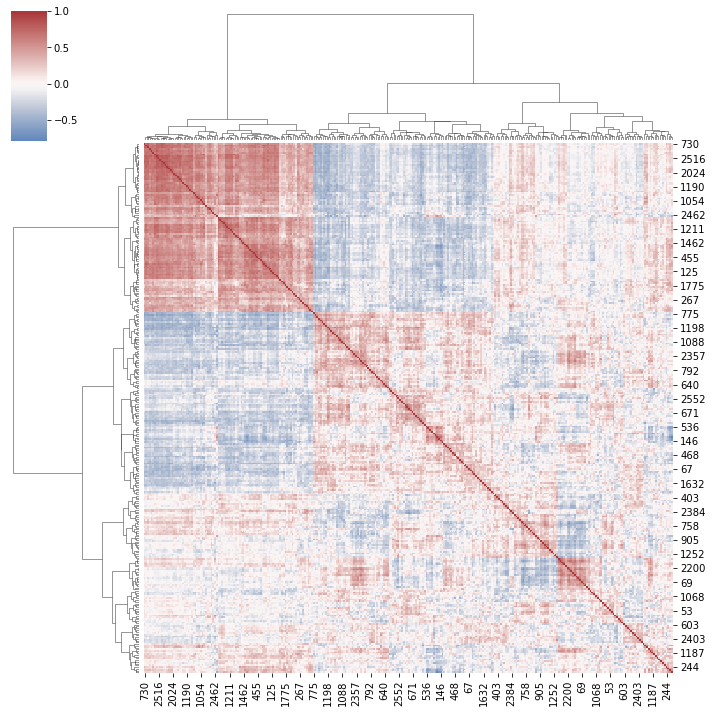

In [56]:
sns.clustermap(pd.DataFrame(minmax_df_quant).loc[:,anova_set].corr(), method='ward', metric="euclidean", cmap="vlag", center = 0)

In [8]:
1-abs(pd.DataFrame(minmax_df_quant).loc[:,MI_set].corr())

,1026,2572,1020,1555,1047,1575,2093,2094,559,50,...,987,479,996,998,490,493,2550,2038,2552,508
1026,0.000000,0.947083,0.882966,0.945670,0.998880,0.844312,0.808829,0.597082,0.985515,0.688654,...,0.797527,0.829002,0.871141,0.757559,0.991044,0.817438,0.777314,0.708231,0.803970,0.687583
2572,0.947083,0.000000,0.977601,0.891107,0.346307,0.599503,0.756410,0.601643,0.953025,0.717015,...,0.719076,0.801082,0.843084,0.746022,0.935034,0.802892,0.942036,0.950688,0.731680,0.598195
1020,0.882966,0.977601,0.000000,0.663006,0.784945,0.795899,0.987121,0.893578,0.928351,0.909944,...,0.979010,0.974038,0.973541,0.995069,0.828088,0.865550,0.774517,0.892179,0.737869,0.920091
1555,0.945670,0.891107,0.663006,0.000000,0.895617,0.849379,0.753001,0.817266,0.986474,0.762534,...,0.673948,0.719650,0.774517,0.804147,0.993430,0.850032,0.889591,0.970149,0.821026,0.822393
1047,0.998880,0.346307,0.784945,0.895617,0.000000,0.449370,0.663888,0.717369,0.777619,0.730034,...,0.692749,0.727372,0.792652,0.860214,0.737116,0.666803,0.948503,0.963622,0.886375,0.564826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.817438,0.802892,0.865550,0.850032,0.666803,0.722079,0.805611,0.984131,0.947043,0.983338,...,0.919422,0.814814,0.881352,0.945467,0.888028,0.000000,0.969022,0.860264,0.787310,0.906853
2550,0.777314,0.942036,0.774517,0.889591,0.948503,0.703129,0.974815,0.879756,0.434749,0.998901,...,0.864017,0.994278,0.872834,0.933116,0.257846,0.969022,0.000000,0.758533,0.615609,0.688055
2038,0.708231,0.950688,0.892179,0.970149,0.963622,0.723467,0.900645,0.608975,0.867907,0.738394,...,0.943795,0.995212,0.924139,0.673172,0.643067,0.860264,0.758533,0.000000,0.815785,0.908693
2552,0.803970,0.731680,0.737869,0.821026,0.886375,0.929538,0.872053,0.922330,0.918365,0.935682,...,0.790776,0.924842,0.892409,0.987294,0.832435,0.787310,0.615609,0.815785,0.000000,0.941980


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


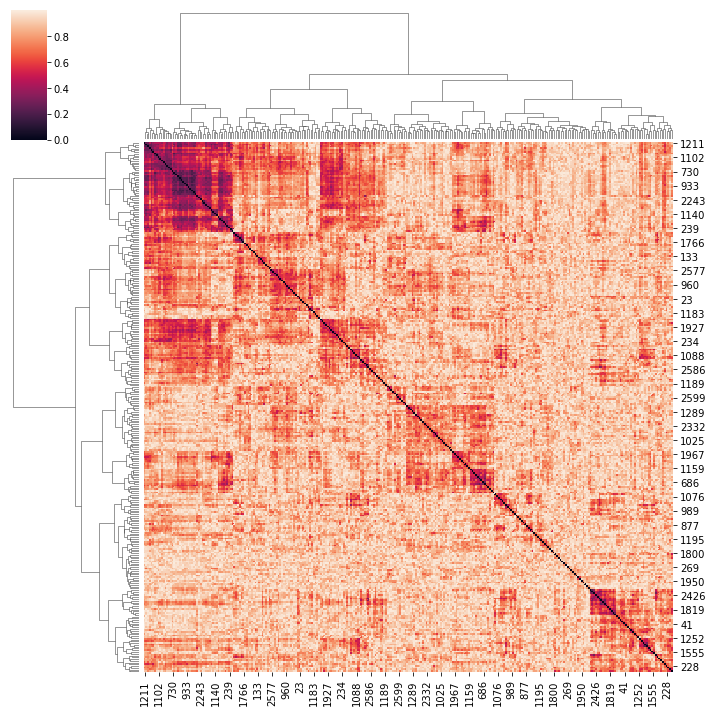

In [57]:
sns.clustermap(1-abs(pd.DataFrame(minmax_df_quant).loc[:,MI_set].corr()), method='ward')

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


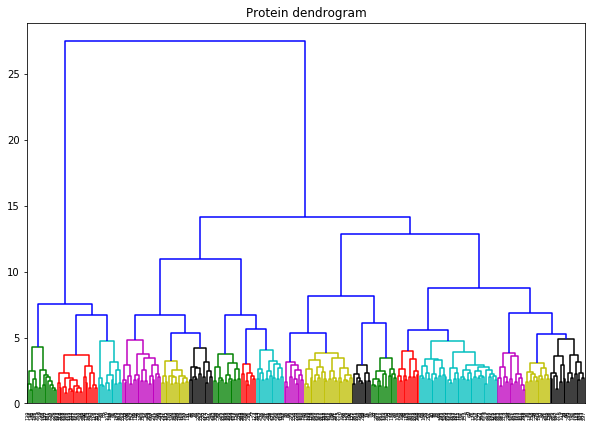

In [58]:
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import squareform

plt.figure(figsize=(10, 7))
plt.title("Protein dendrogram")

# Selecting Annual Income and Spending Scores by index
clusters = sch.linkage(1-abs(pd.DataFrame(minmax_df_quant).loc[:,MI_set].corr()), 
            method='ward',metric="euclidean")

sch.dendrogram(Z=clusters, color_threshold=5)
cluster_labels = sch.fcluster(clusters, t=5, criterion="distance")
plt.show()

In [61]:
protein_names = np.array(list(MI_set))
protein_names= protein_columns[protein_names]

In [67]:
protein_names

Index(['Q04446', 'A0MZ66', 'Q86XP3', 'A2RRP1', 'Q04721', 'P18206', 'P18583',
       'P17655', 'Q9Y5B9', 'A6NHT5',
       ...
       'P16403', 'P16435', 'Q9BW60', 'P16930', 'Q01970', 'Q9BWF3', 'Q9Y446',
       'Q9Y490', 'Q02952', 'Q03252'],
      dtype='object', length=300)

In [66]:
# Cluster 16: cytoskeleteal proteins
# Cluster 2: preribosome, splicing factors and chromosome related proteins

for x in protein_names[cluster_labels == 13]:
    print(x)

Q86XP3
P21266
Q9H0A0
P22695
Q9H583
Q8NEJ9
Q8TAQ2
P39019
P41252
Q15149
P78406
Q00325
P14866
Q00839


Fitted RF
Fitted SVC
Fitted LR


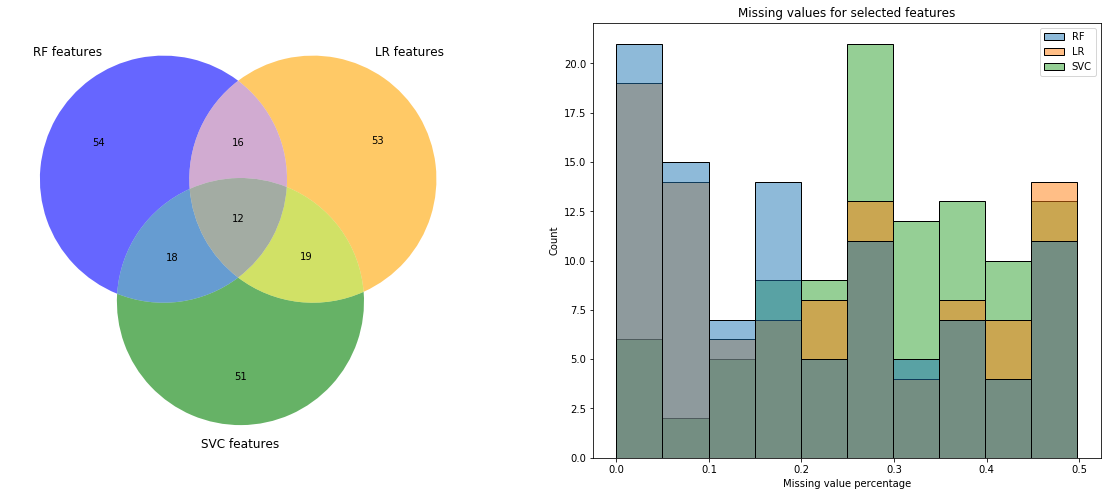

In [83]:
estimator_rf = RandomForestClassifier(class_weight=weights)
selector_rf = RFE(estimator_rf, n_features_to_select=100, step=50)
selector_rf = selector_rf.fit(minmax_df_quant, targets)

print("Fitted RF")

estimator_svc = SVC(kernel="linear", class_weight=weights)
selector_svc = RFE(estimator_svc, n_features_to_select=100, step=50)
selector_svc = selector_svc.fit(minmax_df_quant, targets)

print("Fitted SVC")

selector_lr = RFE(LogisticRegression(penalty="l1", solver = "liblinear", multi_class="ovr", class_weight=weights), n_features_to_select=100, step=50)
selector_lr = selector_lr.fit(minmax_df_quant, targets)

print("Fitted LR")

rf_f = pd.Series(selector_rf.get_support()).reset_index(name = "RF").rename(columns = {"index":"path_id"})
rf_f = rf_f[rf_f.RF]
lr_f = pd.Series(selector_lr.get_support()).reset_index(name = "LR").rename(columns = {"index":"path_id"})
lr_f = lr_f[lr_f.LR]
svc_f = pd.Series(selector_svc.get_support()).reset_index(name = "SVC").rename(columns = {"index":"path_id"})
svc_f = svc_f[svc_f.SVC]

fig, ax = plt.subplots(1,2, figsize= (20,8), facecolor = "white")

rf_set = set(rf_f.path_id)
lr_set = set(lr_f.path_id)
svc_set = set(svc_f.path_id)


venn.venn3([rf_set, lr_set, svc_set], ("RF features", "LR features", "SVC features"), ax=ax[0], set_colors=("blue", "orange", "green") ,alpha=.6)

missing_percentage = pd.concat([data_combat.loc[:, rf_set].isna().sum().reset_index(drop=True) / 518, 
                                data_combat.loc[:, lr_set].isna().sum().reset_index(drop=True) / 518, 
                                data_combat.loc[:, svc_set].isna().sum().reset_index(drop=True) / 518],
          axis=1, ignore_index=True)

ax[1].set_title("Missing values for selected features")
ax[1].set_xlabel("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "RF", 1: "LR", 2: "SVC"}), ax=ax[1])

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fea1f518490>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fea36301810>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fea362633d0>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fea3c8aa150>}

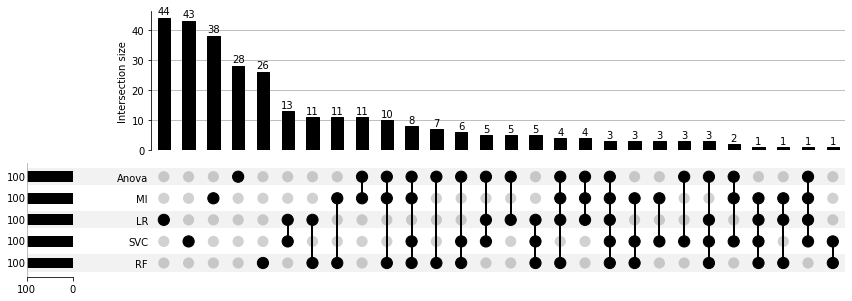

In [95]:
# Overlap for top 100
contents = uplt.from_contents({"Anova": anova_set, "MI": MI_set, "LR": lr_set, "SVC": svc_set, "RF": rf_set})
uplt.plot(contents, show_counts = True, sort_by = "cardinality")

In [96]:
protein_columns[list(set.intersection(anova_set,  MI_set, lr_set, svc_set, rf_set))]

Index(['P43121', 'Q96CX2', 'P05787'], dtype='object')

Fitted RF
Fitted SVC
Fitted LR


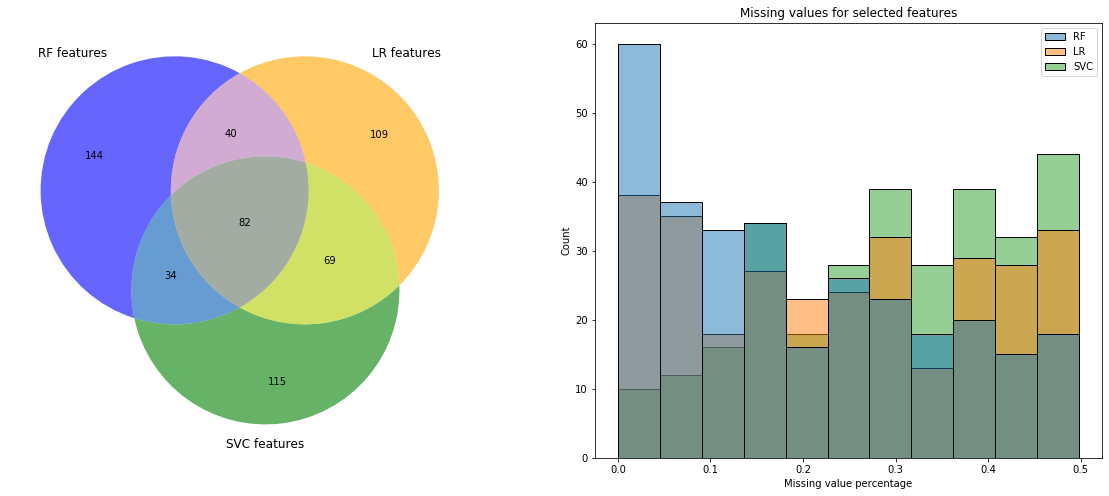

In [40]:
estimator_rf = RandomForestClassifier(class_weight=weights)
selector_rf = RFE(estimator_rf, n_features_to_select=100, step=50)
selector_rf = selector_rf.fit(minmax_df_quant, targets)

print("Fitted RF")

estimator_svc = SVC(kernel="linear", class_weight=weights)
selector_svc = RFE(estimator_svc, n_features_to_select=100, step=50)
selector_svc = selector_svc.fit(minmax_df_quant, targets)

print("Fitted SVC")

selector_lr = RFE(LogisticRegression(penalty="l1", solver = "liblinear", multi_class="ovr", class_weight=weights), n_features_to_select=100, step=50)
selector_lr = selector_lr.fit(minmax_df_quant, targets)

print("Fitted LR")

rf_f = pd.Series(selector_rf.get_support()).reset_index(name = "RF").rename(columns = {"index":"path_id"})
rf_f = rf_f[rf_f.RF]
lr_f = pd.Series(selector_lr.get_support()).reset_index(name = "LR").rename(columns = {"index":"path_id"})
lr_f = lr_f[lr_f.LR]
svc_f = pd.Series(selector_svc.get_support()).reset_index(name = "SVC").rename(columns = {"index":"path_id"})
svc_f = svc_f[svc_f.SVC]

fig, ax = plt.subplots(1,2, figsize= (20,8), facecolor = "white")

rf_set = set(rf_f.path_id)
lr_set = set(lr_f.path_id)
svc_set = set(svc_f.path_id)


venn.venn3([rf_set, lr_set, svc_set], ("RF features", "LR features", "SVC features"), ax=ax[0], set_colors=("blue", "orange", "green") ,alpha=.6)

missing_percentage = pd.concat([data_combat.loc[:, rf_set].isna().sum().reset_index(drop=True) / 518, 
                                data_combat.loc[:, lr_set].isna().sum().reset_index(drop=True) / 518, 
                                data_combat.loc[:, svc_set].isna().sum().reset_index(drop=True) / 518],
          axis=1, ignore_index=True)

ax[1].set_title("Missing values for selected features")
ax[1].set_xlabel("Missing value percentage")
sns.histplot(data=missing_percentage.rename(columns={0: "RF", 1: "LR", 2: "SVC"}), ax=ax[1])

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fea245b5cd0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fea1ebf23d0>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fea3c1a6810>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fea24337490>}

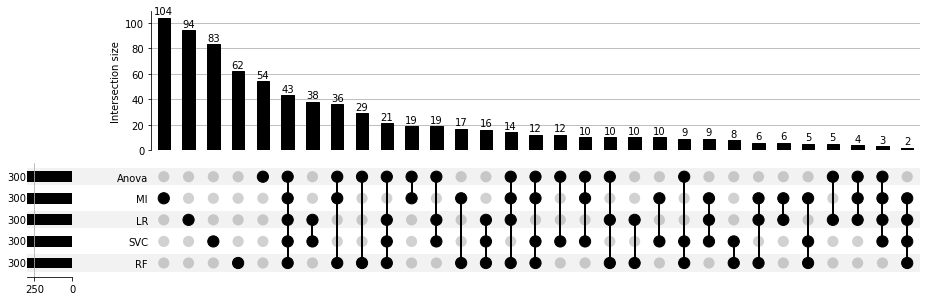

In [59]:
# Overlap for top 300
contents = uplt.from_contents({"Anova": anova_set, "MI": MI_set, "LR": lr_set, "SVC": svc_set, "RF": rf_set})
uplt.plot(contents, show_counts = True, sort_by = "cardinality")

In [60]:
protein_columns[list(set.intersection(anova_set,  MI_set, lr_set, svc_set, rf_set))]

Index(['A0MZ66', 'P05787', 'Q96TA1', 'Q14126', 'Q14151', 'Q8IVF2', 'Q9BZK3',
       'Q3KQU3', 'P35580', 'Q9Y5Z4', 'Q14315', 'P35998', 'Q9C0C2', 'Q96CX2',
       'P20700', 'Q8TEM1', 'P08670', 'Q9NZN4', 'P62805', 'P21980', 'Q14676',
       'Q6WKZ4', 'O00425', 'Q8WUF5', 'P62877', 'P11388', 'Q12965', 'Q8N392',
       'P26447', 'P27105', 'P43121', 'P29350', 'P46821', 'Q92820', 'Q9UHD8',
       'P15924', 'P16144', 'P30740', 'Q9UIG0', 'P48681', 'P05091', 'P48960',
       'Q02952'],
      dtype='object')

In [1]:
for x in ['A0MZ66', 'P05787', 'Q96TA1', 'Q14126', 'Q14151', 'Q8IVF2', 'Q9BZK3',
       'Q3KQU3', 'P35580', 'Q9Y5Z4', 'Q14315', 'P35998', 'Q9C0C2', 'Q96CX2',
       'P20700', 'Q8TEM1', 'P08670', 'Q9NZN4', 'P62805', 'P21980', 'Q14676',
       'Q6WKZ4', 'O00425', 'Q8WUF5', 'P62877', 'P11388', 'Q12965', 'Q8N392',
       'P26447', 'P27105', 'P43121', 'P29350', 'P46821', 'Q92820', 'Q9UHD8',
       'P15924', 'P16144', 'P30740', 'Q9UIG0', 'P48681', 'P05091', 'P48960',
       'Q02952']:
       print(x)

A0MZ66
P05787
Q96TA1
Q14126
Q14151
Q8IVF2
Q9BZK3
Q3KQU3
P35580
Q9Y5Z4
Q14315
P35998
Q9C0C2
Q96CX2
P20700
Q8TEM1
P08670
Q9NZN4
P62805
P21980
Q14676
Q6WKZ4
O00425
Q8WUF5
P62877
P11388
Q12965
Q8N392
P26447
P27105
P43121
P29350
P46821
Q92820
Q9UHD8
P15924
P16144
P30740
Q9UIG0
P48681
P05091
P48960
Q02952


---

In [41]:
lr_clf = LogisticRegression(max_iter=10000, class_weight=weights)
svm_clf = SVC(class_weight=weights)
rf_clf = RandomForestClassifier(class_weight=weights)
lgbm_clf = lgbm(class_weight=weights)

models = [lr_clf, svm_clf, rf_clf, lgbm_clf]

In [42]:
skf = StratifiedKFold(n_splits=10, shuffle=True)


selectors = "anova MI LR RF SVC".split()
model_names = "lr svm rf lgbm".split()
model_scores = {f:{x:[] for x in selectors} for f in model_names}

fold = 0
for train, test in skf.split(X=data_quantile, y=targets):
    print(fold)

    X_train = data_quantile.loc[train, :].reset_index(drop=True)
    X_test = data_quantile.loc[test,:].reset_index(drop=True)

    Y_train = targets[train]
    Y_test = targets[test]

    #imputer = uml.MNAR_MCAR_Imputer(max_iter=15)
    imputer = uml.LowestValueImputerGaussian()
    imputer.fit(X_train, Y_train)
    imputed_train = imputer.transform(X_train, Y_train)
    imputed_test = imputer.transform(X_test)

    for selector in selectors:
        fs = uml.FeatureSelector(selectors=[selector], num_features=100)
        fs.fit(imputed_train, Y_train)
        X_train_fs = fs.transform(imputed_train)
        X_test_fs = fs.transform(imputed_test)

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_fs)
        X_test_scaled = scaler.fit_transform(X_test_fs)
    
        for model_i,model in enumerate(models):

                model.fit(X_train_scaled, Y_train)

                Y_pred = model.predict(X_test_scaled)
            
                micro_f1, macro_f1, weighted_f1, _ = uml.scoring_functions(Y_pred=Y_pred, Y_test=Y_test, labels=unique_labels)
                results_df = pd.DataFrame({"model": [type(model).__name__], "fold": [fold], "micro_f1": [micro_f1],
                                        "macro_f1": [macro_f1], "weighted_f1": [weighted_f1],
                                        "selector": [selector]})
                model_scores[model_names[model_i]][selector].append(macro_f1)
                uml.save_results(results_df, "fs_comparison_LVIG")
    fold+=1

0
1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Mean macro F1-score over 10 folds')

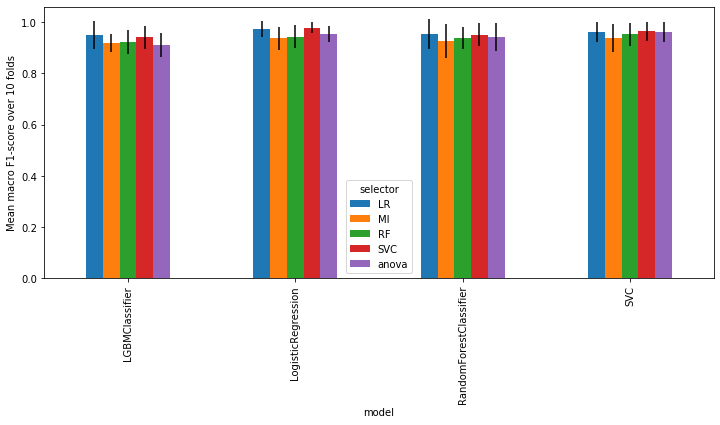

In [23]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
fs_comparison = pd.read_csv("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/ML/results/fs_comparison_LVIG_100.csv", sep=";")
fs_comparison.groupby(["model", "selector"]).mean().macro_f1.unstack().plot(kind="bar", ax=ax,
            yerr=fs_comparison.groupby(["model", "selector"]).std().macro_f1.unstack())
ax.set_ylabel("Mean macro F1-score over 10 folds")

In [25]:
fs_comparison.groupby(["model", "selector"]).mean().macro_f1.sort_values(ascending=False)

model                   selector
LogisticRegression      SVC         0.978473
                        LR          0.974248
SVC                     SVC         0.965093
                        LR          0.962725
                        anova       0.962470
RandomForestClassifier  LR          0.954256
LogisticRegression      anova       0.953983
SVC                     RF          0.953536
RandomForestClassifier  SVC         0.951492
LGBMClassifier          LR          0.950657
LogisticRegression      RF          0.944238
RandomForestClassifier  anova       0.942472
LGBMClassifier          SVC         0.941832
RandomForestClassifier  RF          0.939241
SVC                     MI          0.938199
LogisticRegression      MI          0.936825
RandomForestClassifier  MI          0.926550
LGBMClassifier          RF          0.923334
                        MI          0.917826
                        anova       0.911170
Name: macro_f1, dtype: float64

In [43]:
model_names = []
selector_names = []
scores__ = []
for model_name, fs_dict in model_scores.items():
    for f_name, scores_ in fs_dict.items():
        print("Model:",model_name, "\tSelector:",f_name, "\tAvg score:", np.mean(scores_))
        
        for s in scores_:
            model_names.append(model_name)
            selector_names.append(f_name)
            scores__.append(s)


Model: lr 	Selector: anova 	Avg score: 0.9735824175824176
Model: lr 	Selector: MI 	Avg score: 0.9641682398555463
Model: lr 	Selector: LR 	Avg score: 0.968924039611346
Model: lr 	Selector: RF 	Avg score: 0.9507845572613375
Model: lr 	Selector: SVC 	Avg score: 0.9818251813545931
Model: svm 	Selector: anova 	Avg score: 0.9641553084596562
Model: svm 	Selector: MI 	Avg score: 0.933154221572986
Model: svm 	Selector: LR 	Avg score: 0.9483327976371454
Model: svm 	Selector: RF 	Avg score: 0.9631787332931498
Model: svm 	Selector: SVC 	Avg score: 0.9585308121829861
Model: rf 	Selector: anova 	Avg score: 0.964374528120658
Model: rf 	Selector: MI 	Avg score: 0.9358846322535245
Model: rf 	Selector: LR 	Avg score: 0.9688423531818335
Model: rf 	Selector: RF 	Avg score: 0.9524045214045213
Model: rf 	Selector: SVC 	Avg score: 0.964840166369578
Model: lgbm 	Selector: anova 	Avg score: 0.9289025610898676
Model: lgbm 	Selector: MI 	Avg score: 0.9326257582573373
Model: lgbm 	Selector: LR 	Avg score: 0.96809

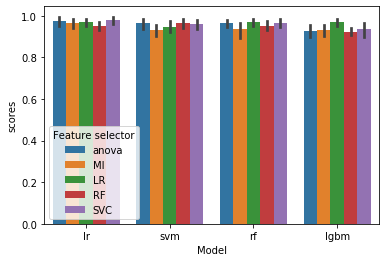

In [44]:
sns.barplot(data=pd.DataFrame({"Model": model_names, "Feature selector": selector_names, "scores": scores__}),
            x="Model", hue="Feature selector", y="scores")

---

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fec8e3e4a10>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fec8e489f90>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fec8e452750>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fec8e2fe150>}

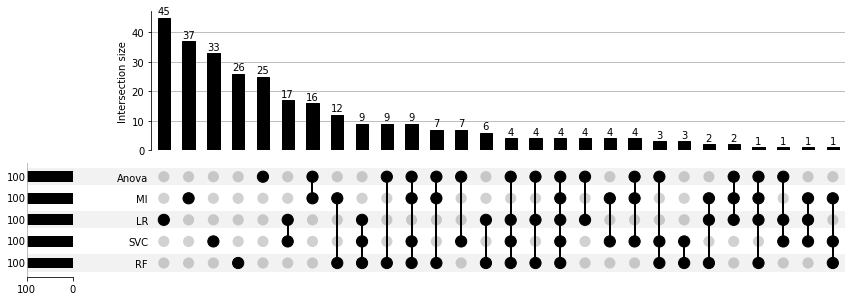

In [76]:
contents = uplt.from_contents({"Anova": anova_set, "MI": MI_set, "LR": lr_set, "SVC": svc_set, "RF": rf_set})
uplt.plot(contents, show_counts = True, sort_by = "cardinality")

In [80]:
protein_columns[list(set.intersection(anova_set,  MI_set, lr_set, svc_set, rf_set))]

Index(['P11388', 'Q96CX2', 'P48681', 'Q9P2M7'], dtype='object')

# Comparing Normalization and imputation combination on feature selection

In [47]:
def overlap_fs(dataset):

    # Imputations
    scaler = MinMaxScaler()
    dataset_minmax = scaler.fit_transform(dataset)

    lod_imp = uml.LowestValueImputerGaussian()
    knn_imp = KNNImputer(n_neighbors=10)
    dataset_pca, _, _ = uml.PCA_imputation(dataset= dataset, max_iter=15)
    mcar_lod_imp = uml.MNAR_MCAR_Imputer(max_iter=15)
    mcar_lod_imp.fit(dataset, targets)

    dataset_lod = lod_imp.fit_transform(dataset)
    print("LOD imputed")
    dataset_knn_mm = knn_imp.fit_transform(dataset_minmax)
    print("KNN imputed")
    dataset_pca_lod = mcar_lod_imp.transform(dataset,targets)
    print("PCA+LOD imputed")
    dataset_knn_lod = mcar_lod_imp.X_knn_imputed
    print("KNN+LOD imputed")

    # Feature selection
    dataset_lod_mm = pd.DataFrame(scaler.fit_transform(dataset_lod))
    dataset_pca_mm = pd.DataFrame(scaler.fit_transform(dataset_pca))
    dataset_knn_mm = pd.DataFrame(dataset_knn_mm)
    dataset_pca_lod_mm = pd.DataFrame(scaler.fit_transform(dataset_pca_lod))
    dataset_knn_lod_mm = pd.DataFrame(scaler.fit_transform(dataset_knn_lod))

    fs = uml.FeatureSelector(selectors=["anova", "MI", "LR", "SVC", "RF"], num_features=300, threshold=.5)
    lod_fs = fs.fit_transform(dataset_lod_mm, targets)
    knn_fs = fs.fit_transform(dataset_knn_mm, targets)
    pca_fs = fs.fit_transform(dataset_pca_mm, targets)
    pca_lod_fs = fs.fit_transform(dataset_pca_lod_mm, targets)
    knn_lod_fs = fs.fit_transform(dataset_knn_lod_mm, targets)

    contents = uplt.from_contents({"LOD": set(lod_fs.columns), 
                                "KNN": set(knn_fs.columns),
                                "PCA": set(pca_fs.columns),
                                "KNN+LOD": set(knn_lod_fs.columns),
                                "PCA+LOD": set(pca_lod_fs.columns)})

    uplt.plot(contents, show_counts = True, sort_by="cardinality")

    selected_features = {"LOD": set(lod_fs.columns), 
                        "KNN": set(knn_fs.columns),
                        "PCA": set(pca_fs.columns),
                        "KNN+LOD": set(knn_lod_fs.columns),
                        "PCA+LOD": set(pca_lod_fs.columns)}

    return selected_features

First iteration: 0
iteration: 0
Components: 367
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
LOD imputed
KNN imputed
First iteration: 0
iteration: 0
Components: 357
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
PCA+LOD imputed
KNN+LOD imputed
First iteration: 0
iteration: 0
Components: 341
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
LOD imputed
KNN imputed
First iteration: 0
iteration: 0
Components: 326
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteratio

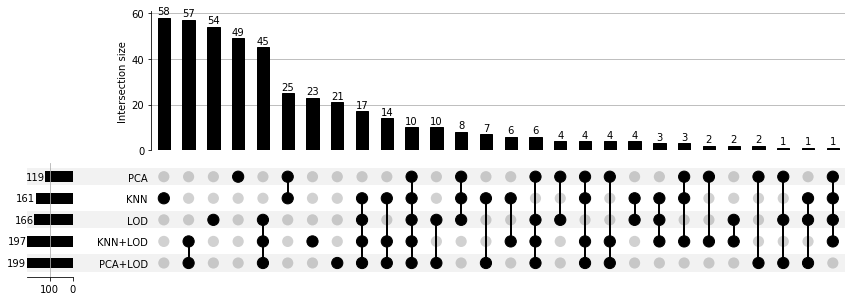

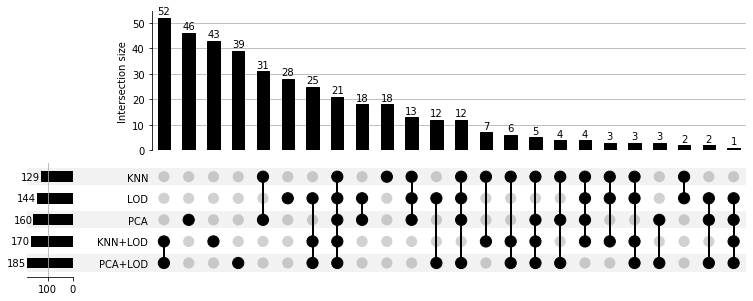

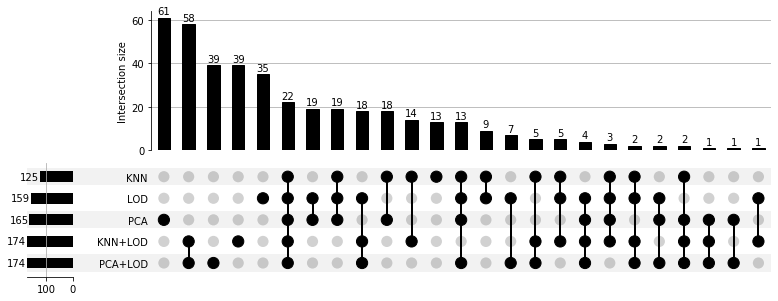

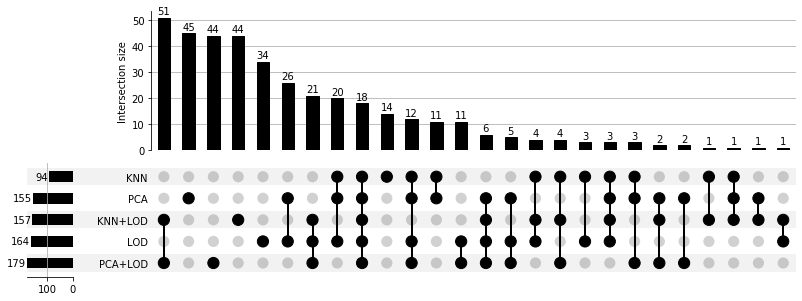

In [48]:
combat_fs = overlap_fs(data_combat)
nsaf_fs = overlap_fs(data_nsaf)
med_fs = overlap_fs(data_median_norm)
quant_fs = overlap_fs(data_quantile)

In [49]:
contents_across_norm = {}
for key in combat_fs.keys():
    contents = uplt.from_contents({"NSAF": nsaf_fs[key],
                                   "ComBat": combat_fs[key],
                                   "Median Norm": med_fs[key],
                                   "Quantile": quant_fs[key]})
    contents_across_norm[key] = contents

LOD
KNN
PCA
KNN+LOD
PCA+LOD


{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fea1f3333d0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fea1f110050>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fea2433fc50>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fea1f758610>}

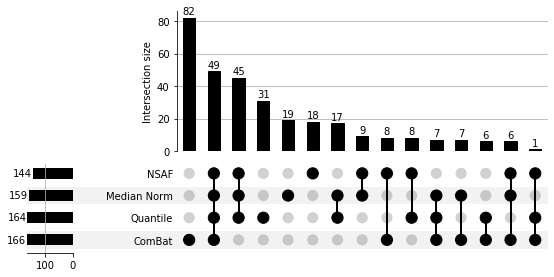

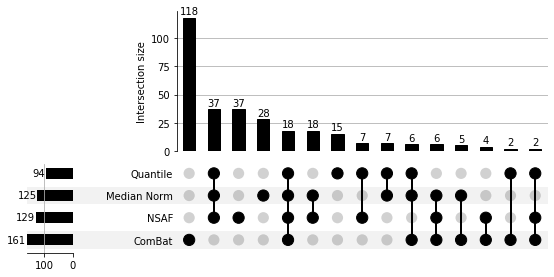

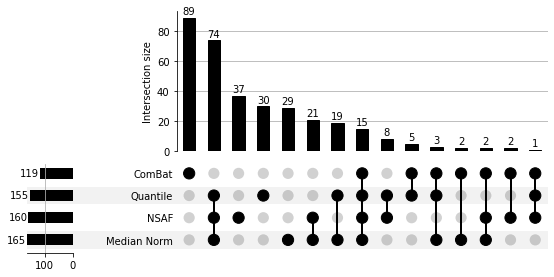

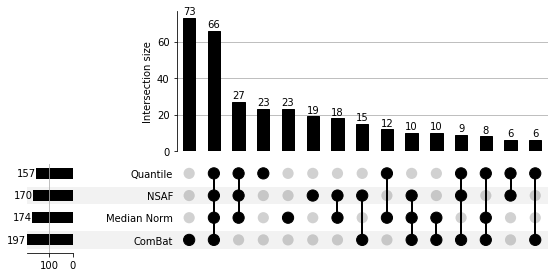

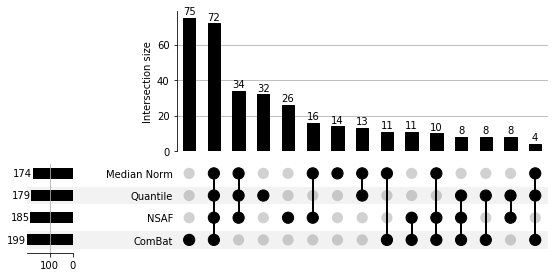

In [50]:
print("LOD")
uplt.plot(contents_across_norm["LOD"], show_counts = True, sort_by = "cardinality")
print("KNN")
uplt.plot(contents_across_norm["KNN"], show_counts = True, sort_by = "cardinality")
print("PCA")
uplt.plot(contents_across_norm["PCA"], show_counts = True, sort_by = "cardinality")
print("KNN+LOD")
uplt.plot(contents_across_norm["KNN+LOD"], show_counts = True, sort_by = "cardinality")
print("PCA+LOD")
uplt.plot(contents_across_norm["PCA+LOD"], show_counts = True, sort_by = "cardinality")

---

First iteration: 0
iteration: 0
Components: 367
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
LOD imputed
KNN imputed
First iteration: 0
iteration: 0
Components: 357
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
PCA+LOD imputed
KNN+LOD imputed
First iteration: 0
iteration: 0
Components: 341
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
LOD imputed
KNN imputed
First iteration: 0
iteration: 0
Components: 326
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteratio

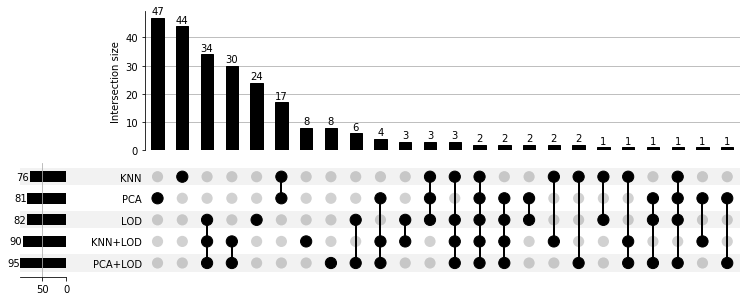

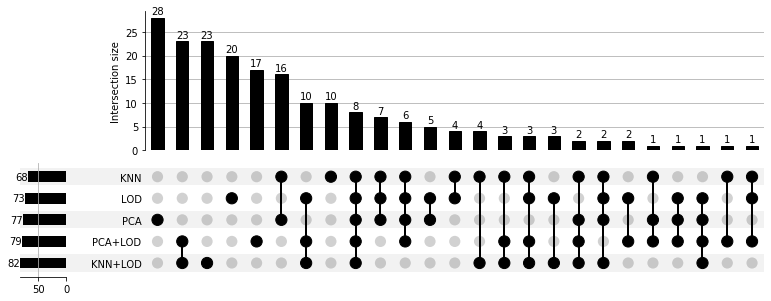

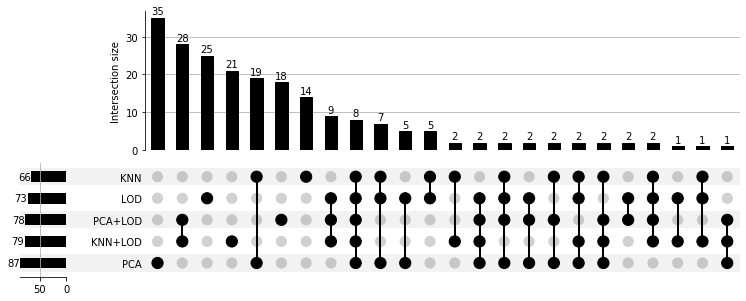

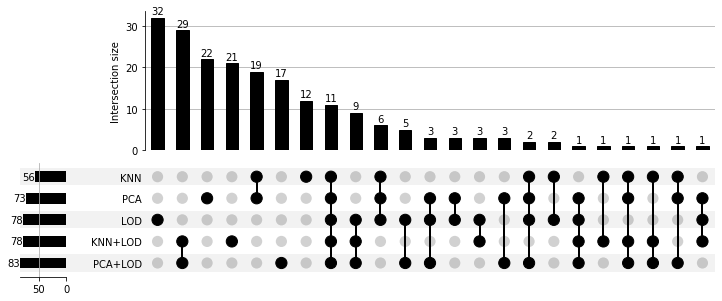

In [7]:
combat_fs = overlap_fs(data_combat)
nsaf_fs = overlap_fs(data_nsaf)
med_fs = overlap_fs(data_median_norm)
quant_fs = overlap_fs(data_quantile)

In [8]:
contents_across_norm = {}
for key in combat_fs.keys():
    contents = uplt.from_contents({"NSAF": nsaf_fs[key],
                                   "ComBat": combat_fs[key],
                                   "Median Norm": med_fs[key],
                                   "Quantile": quant_fs[key]})
    contents_across_norm[key] = contents

In [23]:
contents_across_norm["LOD"]

id
NSAF  ComBat Median Norm Quantile      
True  False  True        True         1
False True   False       True         2
      False  False       True         4
True  True   False       True        13
False True   False       False       15
...                                 ...
True  True   True        True      2583
                         True      2586
False False  False       True      2588
True  False  False       False     2593
      True   False       False     2602

[497 rows x 1 columns]

LOD
KNN
PCA
KNN+LOD
PCA+LOD


{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fec8814a5d0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fec8824d910>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fec7ba09350>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fec7b6b9c50>}

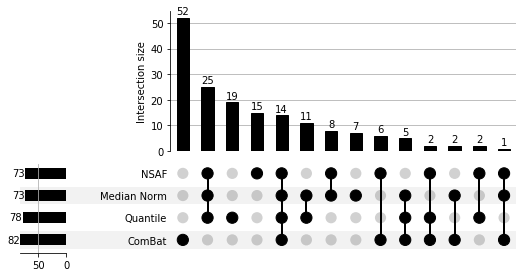

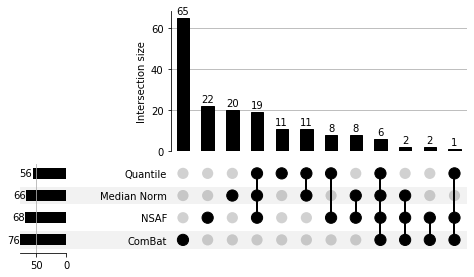

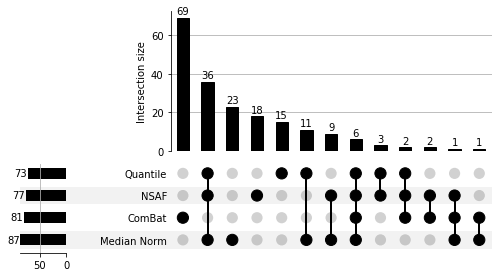

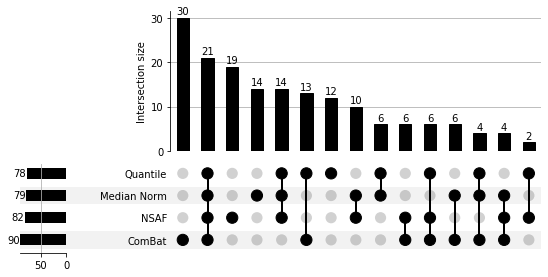

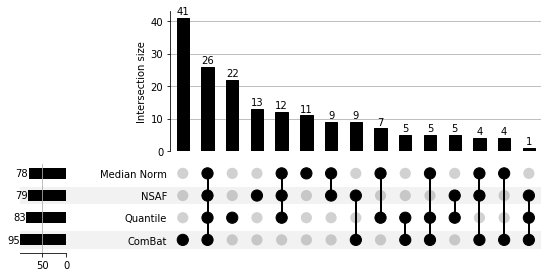

In [10]:
print("LOD")
uplt.plot(contents_across_norm["LOD"], show_counts = True, sort_by = "cardinality")
print("KNN")
uplt.plot(contents_across_norm["KNN"], show_counts = True, sort_by = "cardinality")
print("PCA")
uplt.plot(contents_across_norm["PCA"], show_counts = True, sort_by = "cardinality")
print("KNN+LOD")
uplt.plot(contents_across_norm["KNN+LOD"], show_counts = True, sort_by = "cardinality")
print("PCA+LOD")
uplt.plot(contents_across_norm["PCA+LOD"], show_counts = True, sort_by = "cardinality")

In [62]:
MV_matrix = data_nsaf.isna().sum() / (len(data_nsaf)/2)
MV_matrix.name = "MV"

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


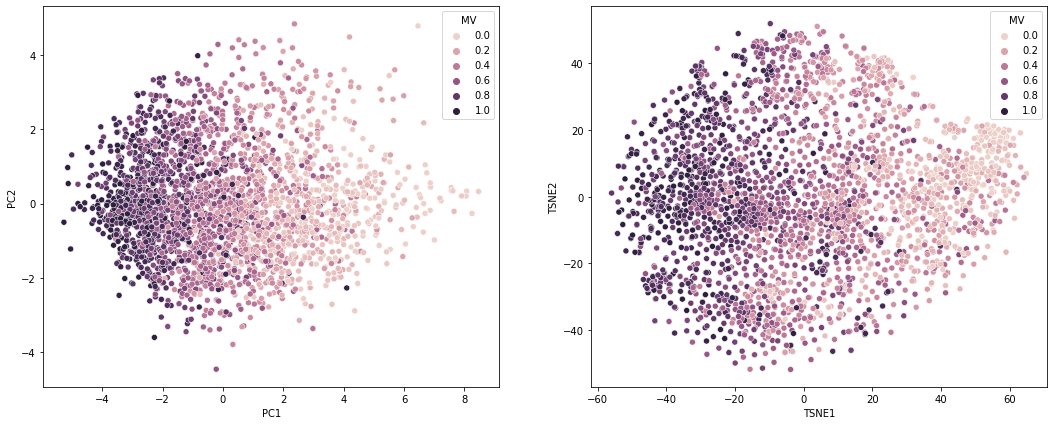

In [54]:
fig, ax = plt.subplots(1,2, figsize=(18,7))

pca_proteins = PCA(n_components=2)

combat_ = pd.DataFrame(minmax_df_quant)

pca_embedding = pd.DataFrame(pca_proteins.fit_transform(combat_.T)).reset_index().merge(MV_matrix.reset_index()).set_index("index").rename(columns={0: "PC1", 1:"PC2"})
tsne_embedding = pd.DataFrame(TSNE(perplexity=10).fit_transform(combat_.T)).reset_index().merge(MV_matrix.reset_index()).set_index("index").rename(columns={0:'TSNE1', 1:"TSNE2"})

sns.scatterplot(data=pca_embedding, x="PC1", y="PC2", hue="MV",ax=ax[0])
sns.scatterplot(data=tsne_embedding, x="TSNE1", y="TSNE2", hue="MV",ax=ax[1])

In [ ]:
class keyProteinSelector(BaseEstimator, TransformerMixin):
    """
    Extracts medioids of clustered proteins. Saves all proteins per cluster to allow functional analysis
    """

    